In [464]:
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import yaml
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [465]:
RUN = "20240826-z1"

In [466]:
matplotlibrc_fn = "../pypsa-eur/matplotlibrc"
config_fn = "../pypsa-eur/config/config.default.yaml"

plt.style.use(["bmh", matplotlibrc_fn])

with open(config_fn, "r") as f:
    config = yaml.safe_load(f)

tech_colors = config["plotting"]["tech_colors"]

In [467]:
fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20240826-z1/postnetworks/base_s_115_lvopt__imp_2050.nc"

In [468]:
ni = pypsa.Network(fn)

INFO:pypsa.io:Imported network base_s_115_lvopt__imp_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [469]:
NICE_NAMES = {
    "import pipeline-h2": "hydrogen",
    "import shipping-lh2": "hydrogen (ship)",
    "import shipping-ftfuel": "Fischer-Tropsch",
    "import shipping-meoh": "methanol",
    "import shipping-lch4": "methane",
    "import shipping-lnh3": "ammonia",
    "import shipping-steel": "steel",
    "import shipping-hbi": "HBI",
}

In [470]:
ni.links["bus0"] = ni.links.bus0.str.replace(" export", "")

In [471]:
min_import_costs = (
    ni.links.filter(like="import", axis=0)
    .groupby([ni.links.carrier, ni.links.bus0, ni.links.bus1])
    .marginal_cost.min()
    .groupby(["carrier", "bus0"])
    .describe()[["min", "max"]]
    .rename(index=NICE_NAMES)
    .drop(
        [
            "import hvdc-to-elec",
            "import infrastructure pipeline-h2",
            "import infrastructure shipping-lh2",
            "import infrastructure shipping-lch4",
        ]
    )
)
min_import_costs.loc[
    min_import_costs.index.get_level_values("carrier").str.contains("steel|HBI")
] *= 2.1
min_import_costs

/tmp/ipykernel_162988/3162040408.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .drop(


min         max
carrier  bus0                                
hydrogen CN-Northeast  139.658927  141.349403
         CN-Southeast  163.135765  164.439262
         CN-West       123.733342  123.897643
         DZ             79.995922   81.214511
         EG             88.094315   88.095068
...                           ...         ...
steel    US-South      592.243975  592.243975
         US-Southeast  652.699638  652.699638
         US-Southwest  587.509585  587.509585
         UY            647.973960  647.973960
         ZA            583.626386  583.626386

[347 rows x 2 columns]

In [472]:
scenarios_fn = {
    "imp+H2": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20240826-z1/postnetworks/base_s_115_lvopt__imp+H2_2050.nc",
    "imp": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20240826-z1/postnetworks/base_s_115_lvopt__imp_2050.nc",
    "noimp": "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20240826-z1/postnetworks/base_s_115_lvopt___2050.nc",
}

scenario_name = "noimp"

fn = scenarios_fn[scenario_name]

In [473]:
n = pypsa.Network(fn)

INFO:pypsa.io:Imported network base_s_115_lvopt___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [474]:
x = (
    n.statistics.energy_balance()
    .xs("co2 stored", level="bus_carrier")
    .div(1e6)
    .round(1)
    .sort_values()
)
x.where(x > 0).sum()  # - 4

545.0

In [475]:
ac_prices = n.buses_t.marginal_price.loc[
    :, (n.buses.carrier == "AC") & (n.buses.index.str.len() != 2)
]
h2_prices = n.buses_t.marginal_price.loc[:, n.buses.carrier == "H2"].rename(
    columns=n.buses.location
)
gas_prices = n.buses_t.marginal_price.loc[:, n.buses.carrier == "gas"].rename(
    columns=n.buses.location
)
biogas_prices = n.buses_t.marginal_price.loc[:, n.buses.carrier == "biogas"].rename(
    columns=n.buses.location
)
heat_prices = (
    n.buses_t.marginal_price.loc[:, n.buses.carrier == "urban central heat"]
    .rename(columns=n.buses.location)
    .reindex(columns=ac_prices.columns)
    .fillna(0.0)
)
nh3_prices = n.buses_t.marginal_price["EU NH3"]
oil_prices = n.buses_t.marginal_price["EU oil"]
steel_prices = n.buses_t.marginal_price["EU steel"]
hbi_prices = n.buses_t.marginal_price["EU HBI"]
meoh_prices = n.buses_t.marginal_price["EU methanol"]
co2_prices = n.buses_t.marginal_price["co2 stored"]
co2_tax = n.buses_t.marginal_price["co2 atmosphere"]

## Breakdown electrolyser market value

In [476]:
mapper = n.links.bus1.map(n.buses.location)
carrier = "H2 Electrolysis"
threshold = 1
weights = n.snapshot_weightings.generators

In [477]:
electrolysers = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(
    index=mapper
)

In [478]:
electrolysers_capex = electrolysers.eval("p_nom_opt * capital_cost").rename(
    index=mapper
)

In [479]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
electrolysers_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
electrolysers_h2 = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
electrolysers_heat = -n.links_t.p2.loc[:, sel].rename(columns=mapper)

In [480]:
electrolysers_h2_output = weights @ electrolysers_h2

In [481]:
## start time series

In [482]:
electrolysers_ac_cost_t = (
    ac_prices[electrolysers.index] * electrolysers_ac
) / electrolysers_h2
electrolysers_heat_revenue_t = (
    heat_prices[electrolysers.index] * electrolysers_heat
) / electrolysers_h2
electrolysers_capex_t = (
    electrolysers_capex
    * electrolysers_h2.mul(weights, axis=0).div(electrolysers_h2_output)
) / electrolysers_h2_output

In [483]:
electrolysers_cost_t = (
    electrolysers_ac_cost_t + electrolysers_heat_revenue_t + electrolysers_capex_t
)

In [484]:
# end time series

In [485]:
electrolysers_ac_cost = weights @ (ac_prices[electrolysers.index] * electrolysers_ac)
electrolysers_h2_revenue = weights @ (h2_prices[electrolysers.index] * electrolysers_h2)
electrolysers_heat_revenue = weights @ (
    heat_prices[electrolysers.index] * electrolysers_heat
)

In [486]:
electrolysers_cost = (
    electrolysers_ac_cost + electrolysers_capex - electrolysers_heat_revenue
) / electrolysers_h2_output

In [487]:
electrolysers_revenue = electrolysers_h2_revenue / electrolysers_h2_output

In [488]:
electrolysers_balance = pd.DataFrame(
    {
        "electricity cost": electrolysers_ac_cost,
        "component cost": electrolysers_capex,
        "heat revenue": -electrolysers_heat_revenue,
        "product revenue": -electrolysers_h2_revenue,
    }
).div(electrolysers_h2_output, axis=0)

electrolysers_balance = pd.Series(
    np.average(electrolysers_balance, weights=electrolysers_h2_output, axis=0),
    index=electrolysers_balance.columns,
)
electrolysers_balance

electricity cost    65.504978
component cost      31.533857
heat revenue        -1.515007
product revenue    -95.539083
dtype: float64

In [489]:
electrolysers_balance.sum()

-0.015254881374147544

## Breakdown Haber-Bosch market value

In [490]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "Haber-Bosch"
threshold = 1
weights = n.snapshot_weightings.generators

In [491]:
haberbosch = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(
    index=mapper
)

In [492]:
haberbosch_capex = haberbosch.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [493]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
haberbosch_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
haberbosch_nh3 = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
haberbosch_h2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)
haberbosch_heat = -n.links_t.p3.loc[:, sel].rename(columns=mapper)

In [494]:
haberbosch_nh3_output = weights @ haberbosch_nh3

In [495]:
haberbosch_ac_cost = weights @ (ac_prices[haberbosch.index] * haberbosch_ac)
haberbosch_h2_cost = weights @ (h2_prices[haberbosch.index] * haberbosch_h2)
haberbosch_nh3_revenue = weights @ haberbosch_nh3.mul(nh3_prices, axis=0)
haberbosch_heat_revenue = weights @ (heat_prices[haberbosch.index] * haberbosch_heat)

In [496]:
haberbosch_cost = (
    haberbosch_ac_cost + haberbosch_h2_cost + haberbosch_capex - haberbosch_heat_revenue
) / haberbosch_nh3_output

In [497]:
haberbosch_revenue = haberbosch_nh3_revenue / haberbosch_nh3_output

In [498]:
haberbosch_balance = pd.DataFrame(
    {
        "electricity cost": haberbosch_ac_cost,
        "hydrogen cost": haberbosch_h2_cost,
        "component cost": haberbosch_capex,
        "heat revenue": -haberbosch_heat_revenue,
        "product revenue": -haberbosch_nh3_revenue,
    }
).div(haberbosch_nh3_output, axis=0)

if haberbosch_nh3_output.sum() != 0:
    haberbosch_balance = pd.Series(
        np.average(haberbosch_balance, weights=haberbosch_nh3_output, axis=0),
        index=haberbosch_balance.columns,
    )
else:
    haberbosch_balance = pd.Series(index=haberbosch_balance.columns)

haberbosch_balance

electricity cost     12.035320
hydrogen cost       111.199534
component cost       18.785294
heat revenue         -8.107394
product revenue    -133.937555
dtype: float64

In [499]:
haberbosch_balance.sum()

-0.024802107273785623

## Breakdown Fischer-Tropsch market value

In [500]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "Fischer-Tropsch"
threshold = 1
weights = n.snapshot_weightings.generators

In [501]:
ft = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(
    index=mapper
)

In [502]:
ft_capex = ft.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [503]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
ft_h2 = n.links_t.p0.loc[:, sel].rename(columns=mapper)
ft_oil = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
ft_co2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)
ft_heat = -n.links_t.p3.loc[:, sel].rename(columns=mapper)

In [504]:
ft_oil_output = weights @ ft_oil

In [505]:
## start time series

In [506]:
ft_co2_cost_t = ft_co2.mul(co2_prices - co2_tax, axis=0) / ft_oil
ft_h2_cost_t = (h2_prices[ft.index] * ft_h2) / ft_oil
ft_oil_revenue_t = (
    ft_oil.mul(oil_prices, axis=0) - ft_co2.mul(co2_tax, axis=0)
) / ft_oil
ft_heat_revenue_t = (heat_prices[ft.index] * ft_heat) / ft_oil
ft_capex_t = (ft_capex * ft_oil.mul(weights, axis=0).div(ft_oil_output)) / ft_oil_output
ft_opex_t = ft.marginal_cost * ft_h2 / ft_oil

In [507]:
ft_cost_t = ft_co2_cost_t + ft_h2_cost_t + ft_opex_t + ft_heat_revenue_t + ft_capex_t

In [508]:
# end time series

In [509]:
ft.marginal_cost * (weights @ ft_h2)

Link
AL0 0    5.609521e+04
AT0 0    3.443114e+04
BE0 0    2.422899e+05
BE0 1    9.898167e+05
BG0 1    6.943132e+04
             ...     
SE1 0    1.029774e+07
SE1 1    5.039469e+07
SE1 2    4.121509e+07
SE1 3    1.086500e+08
SK0 0    4.716444e+04
Length: 69, dtype: float64

In [510]:
ft_co2_cost = weights @ ft_co2.mul(co2_prices - co2_tax, axis=0)
ft_h2_cost = weights @ (h2_prices[ft.index] * ft_h2)
ft_opex = ft.marginal_cost * (weights @ ft_h2)
ft_oil_revenue = weights @ (
    ft_oil.mul(oil_prices, axis=0) - ft_co2.mul(co2_tax, axis=0)
)
ft_heat_revenue = weights @ (heat_prices[ft.index] * ft_heat)

In [511]:
ft_cost = (
    ft_co2_cost + ft_h2_cost + ft_opex + ft_capex - ft_heat_revenue
) / ft_oil_output

In [512]:
ft_revenue = ft_oil_revenue / ft_oil_output

In [513]:
ft_balance = pd.DataFrame(
    {
        "hydrogen cost": ft_h2_cost,
        "carbon dioxide cost": ft_co2_cost,
        "component cost": ft_capex + ft_opex,
        "heat revenue": -ft_heat_revenue,
        "product revenue": -ft_oil_revenue,
    }
).div(ft_oil_output, axis=0)

ft_balance = pd.Series(
    np.average(ft_balance, weights=ft_oil_output, axis=0), index=ft_balance.columns
)
ft_balance

hydrogen cost          122.931987
carbon dioxide cost     37.696828
component cost          13.315687
heat revenue            -1.342346
product revenue       -172.602096
dtype: float64

In [514]:
ft_balance.sum()

6.047722155244628e-05

## Breakdown methanol market value

In [515]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "methanolisation"
threshold = 1
weights = n.snapshot_weightings.generators

In [516]:
meoh = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(
    index=mapper
)

In [517]:
meoh_capex = meoh.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [518]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
meoh_h2 = n.links_t.p0.loc[:, sel].rename(columns=mapper)
meoh_meoh = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
meoh_ac = n.links_t.p2.loc[:, sel].rename(columns=mapper)
meoh_co2 = n.links_t.p3.loc[:, sel].rename(columns=mapper)
meoh_heat = -n.links_t.p4.loc[:, sel].rename(columns=mapper)

In [519]:
meoh_meoh_output = weights @ meoh_meoh

In [520]:
## start time series

In [521]:
meoh_ac_cost_t = (ac_prices[meoh.index] * meoh_ac) / meoh_meoh
meoh_co2_cost_t = meoh_co2.mul(co2_prices - co2_tax, axis=0) / meoh_meoh
meoh_h2_cost_t = (h2_prices[meoh.index] * meoh_h2) / meoh_meoh
meoh_meoh_revenue_t = (
    meoh_meoh.mul(oil_prices, axis=0) - meoh_co2.mul(co2_tax, axis=0)
) / meoh_meoh
meoh_heat_revenue_t = (heat_prices[meoh.index] * meoh_heat) / meoh_meoh
meoh_capex_t = (
    meoh_capex * meoh_meoh.mul(weights, axis=0).div(meoh_meoh_output)
) / meoh_meoh_output

In [522]:
meoh_cost_t = (
    meoh_co2_cost_t
    + meoh_h2_cost_t
    + meoh_ac_cost_t
    + meoh_heat_revenue_t
    + meoh_capex_t
)

In [523]:
# end time series

In [524]:
meoh_co2_cost = weights @ meoh_co2.mul(co2_prices - co2_tax, axis=0)
meoh_h2_cost = weights @ (h2_prices[meoh.index] * meoh_h2)
meoh_ac_cost = weights @ (ac_prices[meoh.index] * meoh_ac)
meoh_meoh_revenue = weights @ (
    meoh_meoh.mul(meoh_prices, axis=0) - meoh_co2.mul(co2_tax, axis=0)
)
meoh_heat_revenue = weights @ (heat_prices[meoh.index] * meoh_heat)

In [525]:
meoh_cost = (
    meoh_co2_cost + meoh_h2_cost + meoh_ac_cost + meoh_capex - meoh_heat_revenue
) / meoh_meoh_output

In [526]:
meoh_revenue = meoh_meoh_revenue / meoh_meoh_output

In [527]:
meoh_balance = pd.DataFrame(
    {
        "electricity cost": meoh_ac_cost,
        "hydrogen cost": meoh_h2_cost,
        "carbon dioxide cost": meoh_co2_cost,
        "component cost": meoh_capex,
        "heat revenue": -meoh_heat_revenue,
        "product revenue": -meoh_meoh_revenue,
    }
).div(meoh_meoh_output, axis=0)

try:
    meoh_balance = pd.Series(
        np.average(meoh_balance, weights=meoh_meoh_output, axis=0),
        index=meoh_balance.columns,
    )
except:
    meoh_balance = pd.Series(index=ft_balance.index)
meoh_balance

electricity cost        12.314400
hydrogen cost          108.899125
carbon dioxide cost     36.363983
component cost          12.457696
heat revenue            -0.446211
product revenue       -169.600373
dtype: float64

In [528]:
meoh_balance.sum()

-0.011379854974649106

## Breakdown methane market value

In [529]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "Sabatier"
threshold = 1
weights = n.snapshot_weightings.generators

In [530]:
sab = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(
    index=mapper
)

In [531]:
sab_capex = sab.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [532]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
sab_h2 = n.links_t.p0.loc[:, sel].rename(columns=mapper)
sab_gas = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
sab_co2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)
sab_heat = -n.links_t.p3.loc[:, sel].rename(columns=mapper)

In [533]:
sab_gas_output = weights @ sab_gas

In [534]:
## start time series

In [535]:
sab_co2_cost_t = sab_co2.mul(co2_prices - co2_tax, axis=0) / sab_gas
sab_h2_cost_t = (h2_prices[sab.index] * sab_h2) / sab_gas
sab_gas_revenue_t = (
    (gas_prices[sab.index] * sab_gas) - sab_co2.mul(co2_tax, axis=0)
) / sab_gas
sab_heat_revenue_t = (heat_prices[sab.index] * sab_heat) / sab_gas
sab_capex_t = (
    sab_capex * sab_gas.mul(weights, axis=0).div(sab_gas_output)
) / sab_gas_output

In [536]:
sab_cost_t = sab_co2_cost_t + sab_h2_cost_t + sab_heat_revenue_t + sab_capex_t

In [537]:
# end time series

In [538]:
sab_co2_cost = weights @ sab_co2.mul(co2_prices - co2_tax, axis=0)
sab_h2_cost = weights @ (h2_prices[sab.index] * sab_h2)
sab_gas_revenue = weights @ (
    (gas_prices[sab.index] * sab_gas) - sab_co2.mul(co2_tax, axis=0)
)
sab_heat_revenue = weights @ (heat_prices[sab.index] * sab_heat)

In [539]:
sab_cost = (sab_co2_cost + sab_h2_cost + sab_capex - sab_heat_revenue) / sab_gas_output

In [540]:
sab_revenue = sab_gas_revenue / sab_gas_output

In [541]:
sab_balance = pd.DataFrame(
    {
        "hydrogen cost": sab_h2_cost,
        "carbon dioxide cost": sab_co2_cost,
        "component cost": sab_capex,
        "heat revenue": -sab_heat_revenue,
        "product revenue": -sab_gas_revenue,
    }
).div(sab_gas_output, axis=0)

try:
    sab_balance = pd.Series(
        np.average(sab_balance, weights=sab_gas_output, axis=0),
        index=sab_balance.columns,
    )
except:
    sab_balance = pd.Series(index=ft_balance.index)
sab_balance

hydrogen cost         NaN
carbon dioxide cost   NaN
component cost        NaN
heat revenue          NaN
product revenue       NaN
dtype: float64

## Biomethane market value

In [542]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "biogas to gas CC"
threshold = 1
weights = n.snapshot_weightings.generators

In [543]:
bio = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(
    index=mapper
)

In [544]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
bio_gas = -n.links_t.p1.loc[:, sel].rename(columns=mapper)

In [545]:
bio_gas_output = weights @ bio_gas

In [546]:
bio_gas_revenue = weights @ (gas_prices[bio.index] * bio_gas)

In [547]:
bio_revenue = bio_gas_revenue / bio_gas_output

In [548]:
bio_bid = (bio_revenue * bio_gas_output).sum() / bio_gas_output.sum()
bio_bid

22.346637313102285

### Fossil gas

In [549]:
n.generators.query("carrier=='gas'").marginal_cost.mean()

24.57736241116268

## Breakdown DRI market value

In [550]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "DRI"
threshold = 1
weights = n.snapshot_weightings.generators

In [551]:
dri = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(
    index=mapper
)

In [552]:
dri_capex = dri.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [553]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
dri_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
dri_hbi = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
dri_h2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)

In [554]:
dri_hbi_output = weights @ dri_hbi

In [555]:
dri_h2_cost = weights @ (h2_prices[dri.index] * dri_h2)
dri_ac_cost = weights @ (ac_prices[dri.index] * dri_ac)
dri_ore_cost = weights @ (dri.marginal_cost * dri_ac)  # since AC is bus0
dri_hbi_revenue = weights @ dri_hbi.mul(steel_prices, axis=0)

In [556]:
dri_cost = (dri_h2_cost + dri_ac_cost + dri_ore_cost + dri_capex) / dri_hbi_output

In [557]:
dri_revenue = dri_hbi_revenue / dri_hbi_output

In [558]:
dri_balance = pd.DataFrame(
    {
        "electricity cost": dri_ac_cost,
        "hydrogen cost": dri_h2_cost,
        "iron ore / HBI cost": dri_ore_cost,
        "component cost": dri_capex,
        "product revenue": -dri_hbi_revenue,
    }
).div(dri_hbi_output, axis=0)

try:
    dri_balance = pd.Series(
        np.average(dri_balance, weights=dri_hbi_output, axis=0),
        index=dri_balance.columns,
    )
except:
    dri_balance = pd.Series(
        index=[
            "electricity cost",
            "hydrogen cost",
            "iron ore / HBI cost",
            "component cost",
            "product revenue",
        ]
    )
dri_balance

electricity cost        51.890726
hydrogen cost          206.563445
iron ore / HBI cost    155.400997
component cost          98.113215
product revenue       -624.843770
dtype: float64

## Breakdown EAF market value

In [559]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "EAF"
threshold = 1
weights = n.snapshot_weightings.generators

In [560]:
eaf = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(
    index=mapper
)

In [561]:
eaf_capex = eaf.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [562]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
eaf_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
eaf_st = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
eaf_hbi = n.links_t.p2.loc[:, sel].rename(columns=mapper)

In [563]:
eaf_st_output = weights @ eaf_st

In [564]:
eaf_hbi_cost = weights @ eaf_hbi.mul(hbi_prices, axis=0)
eaf_ac_cost = weights @ (ac_prices[eaf.index] * eaf_ac)
eaf_st_revenue = weights @ eaf_st.mul(steel_prices, axis=0)

In [565]:
eaf_cost = (eaf_hbi_cost + eaf_ac_cost + eaf_capex) / eaf_st_output

In [566]:
eaf_capex

Link
ES0 6    3.609701e+08
NO1 3    2.992327e+07
SE1 0    3.554197e+09
dtype: float64

In [567]:
eaf_revenue = eaf_st_revenue / eaf_st_output

In [568]:
eaf_balance = pd.DataFrame(
    {
        "electricity cost": eaf_ac_cost,
        "iron ore / HBI cost": eaf_hbi_cost,
        "component cost": eaf_capex,
        "product revenue": -eaf_st_revenue,
    }
).div(eaf_st_output, axis=0)

try:
    eaf_balance = pd.Series(
        np.average(eaf_balance, weights=eaf_st_output, axis=0),
        index=eaf_balance.columns,
    )
except:
    eaf_balance = pd.Series(
        index=[
            "electricity cost",
            "iron ore / HBI cost",
            "component cost",
            "product revenue",
        ]
    )
eaf_balance

electricity cost        34.114639
iron ore / HBI cost    511.968293
component cost          78.754103
product revenue       -624.843770
dtype: float64

In [569]:
import seaborn as sns

pal = sns.color_palette("colorblind", 10)
pal.as_hex()[-1]

'#56b4e9'

In [570]:
colors = {
    "heat revenue": "#d55e00",
    "iron ore / HBI cost": "#56b4e9",
    "component cost": "#de8f05",
    "electricity cost": "#0173b2",
    "hydrogen cost": "#029e73",
    "carbon dioxide cost": "#cc78bc",
}

In [571]:
imports = min_import_costs.stack().unstack("bus0").min(axis=1).unstack()

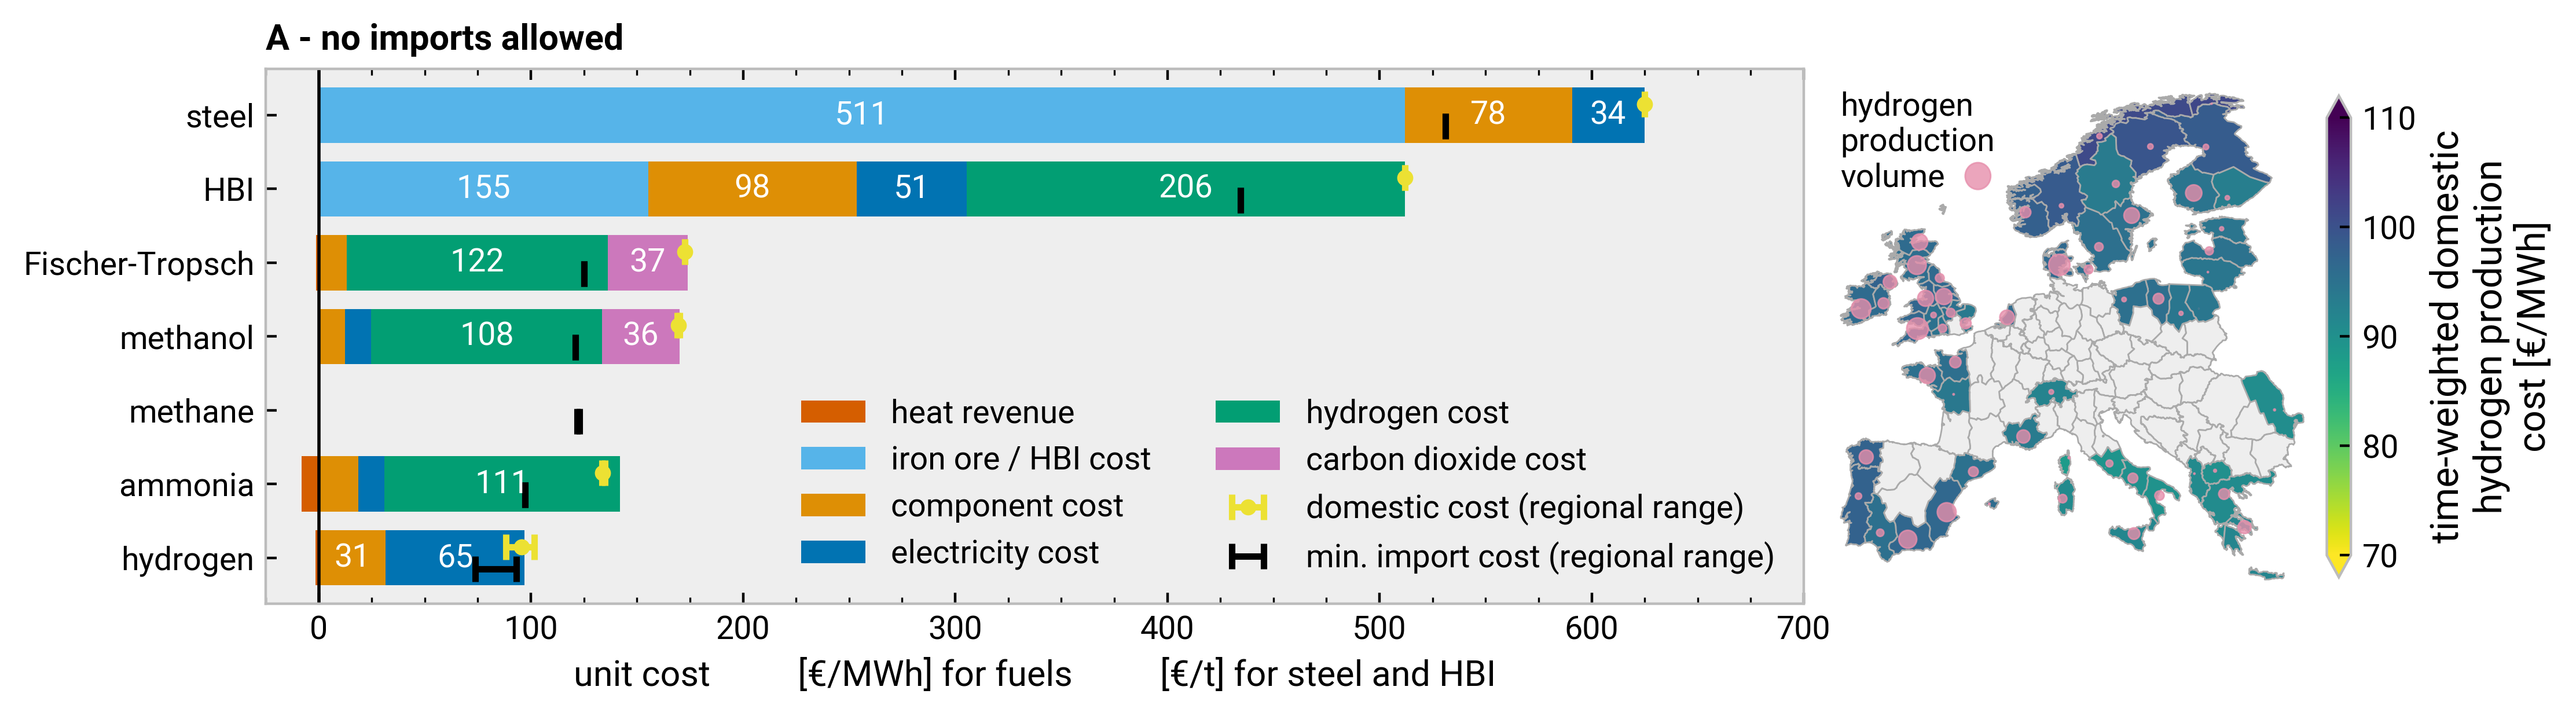

In [572]:
fig, (ax, ax_inset) = plt.subplots(1, 2, figsize=(12, 3), width_ratios=[2.5, 1])

fig.set_tight_layout(False)

plt.subplots_adjust(wspace=0, hspace=0)

composition = pd.concat(
    {
        "hydrogen": electrolysers_balance,
        "ammonia": haberbosch_balance,
        "methane": sab_balance,
        "methanol": meoh_balance,
        "Fischer-Tropsch": ft_balance,
        "HBI": dri_balance,
        "steel": eaf_balance,
    },
    axis=1,
).drop("product revenue")

composition = composition.loc[colors.keys()]

costs = composition.sum()
costs = costs.where(costs > 0)

barh = composition.T.plot.barh(ax=ax, stacked=True, width=0.75, color=colors)

for container in ax.containers:
    ax.bar_label(
        container,
        label_type="center",
        color="white",
        fmt=lambda x: x.astype(int) if x > 25 else "",
    )

errors = (
    pd.concat(
        {
            "hydrogen": electrolysers_cost,
            "ammonia": haberbosch_cost,
            "methane": sab_cost,
            "methanol": meoh_cost,
            "Fischer-Tropsch": ft_cost,
            "HBI": dri_cost,
            "steel": eaf_cost,
        },
        axis=1,
    )
    .describe()
    .loc[["min", "max"]]
    .sub(costs)
    .T.abs()
)

from matplotlib.transforms import Affine2D

trans1 = Affine2D().translate(0.0, 0.15) + ax.transData
trans2 = Affine2D().translate(0.0, -0.15) + ax.transData

ax.errorbar(
    costs,
    composition.columns,
    xerr=errors.T.values,
    fmt=".",
    capsize=4,
    elinewidth=2,
    capthick=2,
    color="#ece133",
    transform=trans1,
    markersize=8,
    label="domestic cost (regional range)",
)

imports = min_import_costs.stack().unstack("bus0").min(axis=1).unstack()
imports = pd.concat(
    {
        "min": imports.groupby(imports.index.str.split(" ").str[0])["min"].min(),
        "max": imports.groupby(imports.index.str.split(" ").str[0])["max"].max(),
    },
    axis=1,
).reindex_like(errors)

ax.errorbar(
    imports.min(axis=1),
    composition.columns,
    xerr=(imports.T - imports.min(axis=1)).values,
    fmt="None",
    capsize=4,
    elinewidth=2,
    capthick=2,
    color="k",
    transform=trans2,
    markersize=8,
    label="min. import cost (regional range)",
)

# ax.scatter(
#     bio_bid,
#     2,
#     marker='o',
#     color=tech_colors["biogas to gas CC"],
#     s=14,
#     label="biogas bid"
# )

# ax.scatter(
#     bio_bid,
#     2,
#     marker='o',
#     color="blue",
#     s=14,
#     label="fossil bid"
# )

ax.axvline(0, color="k", lw=1)

ax.set_xlim(-25, 700)
ax.grid(False)
ax.set_xlabel(
    "unit cost          [€/MWh] for fuels          [€/t] for steel and HBI", fontsize=11
)

ax.set_xticks(range(-25, 700, 25), minor=True)

ax.xaxis.set_label_position("bottom")
# ax.xaxis.tick_top()
ax.xaxis.set_ticks_position("both")

regions_fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/resources/20240826-z1/regions_onshore_base_s_115.geojson"
crs = ccrs.EqualEarth()
regions = gpd.read_file(regions_fn).set_index("name").to_crs(crs.proj4_init)

# left, bottom, width, height = [0.92, 0.1, 0.015, 0.8]
# ax_cbar = fig.add_axes([left, bottom, width, height])
# ax_cbar.grid(False)

regions_plot = regions.plot(
    ax=ax_inset,
    cmap="viridis_r",
    column=electrolysers_cost.reindex(regions.index),
    missing_kwds=dict(color="#eee", label="no electrolysers"),
    linewidth=0.5,
    edgecolor="#aaa",
    # cax=ax_cbar,
    vmin=70,
    vmax=110,
    legend=True,
    legend_kwds={
        "label": "time-weighted domestic\nhydrogen production\ncost [€/MWh]",
        "shrink": 0.9,
        "extend": "both",
        "pad": 0,
        "aspect": 20,
    },
)

bus_coords = n.buses.query("carrier == 'AC'")
bus_gdf = gpd.GeoDataFrame(
    index=bus_coords.index,
    geometry=gpd.points_from_xy(bus_coords.x, bus_coords.y),
    crs="EPSG:4326",
)

bus_gdf.to_crs(crs.proj4_init).plot(
    ax=ax_inset,
    markersize=electrolysers_h2_output.reindex(bus_gdf.index) / 3e6,
    color="#E68FAC",
    alpha=0.8,
)
circle = Circle(
    (0.315, 0.8), 0.025, color="#E68FAC", alpha=0.8, transform=ax_inset.transAxes
)
ax_inset.add_patch(circle)

ax_inset.text(0.045, 0.78, "hydrogen\nproduction\nvolume", transform=ax_inset.transAxes)

ax_inset.axis("off")
ax_inset.set_facecolor("none")

ax.legend(ncol=2, loc="best")

title = {
    "noimp": "A - no imports allowed",
    "imp+H2": "B - only hydrogen imports allowed",
    "imp": "C - all imports allowed",
}
ax.set_title(title[scenario_name], loc="left", fontsize=11, fontweight="bold")

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/market-values-{scenario_name}{ext}", bbox_inches="tight")

In [573]:
abc = {
    "noimp": "A",
    "imp+H2": "B",
    "imp": "C",
}
composition.to_csv(f"{RUN}/figure-4-{abc[scenario_name]}-composition.csv")
errors.to_csv(f"{RUN}/figure-4-{abc[scenario_name]}-domestic-cost-range.csv")
imports.to_csv(f"{RUN}/figure-4-{abc[scenario_name]}-import-cost-range.csv")
electrolysers_h2_output.div(1e6).to_csv(f"{RUN}/figure-4-{abc[scenario_name]}-hydrogen-production.csv")
electrolysers_cost.to_csv(f"{RUN}/figure-4-{abc[scenario_name]}-hydrogen-cost.csv")

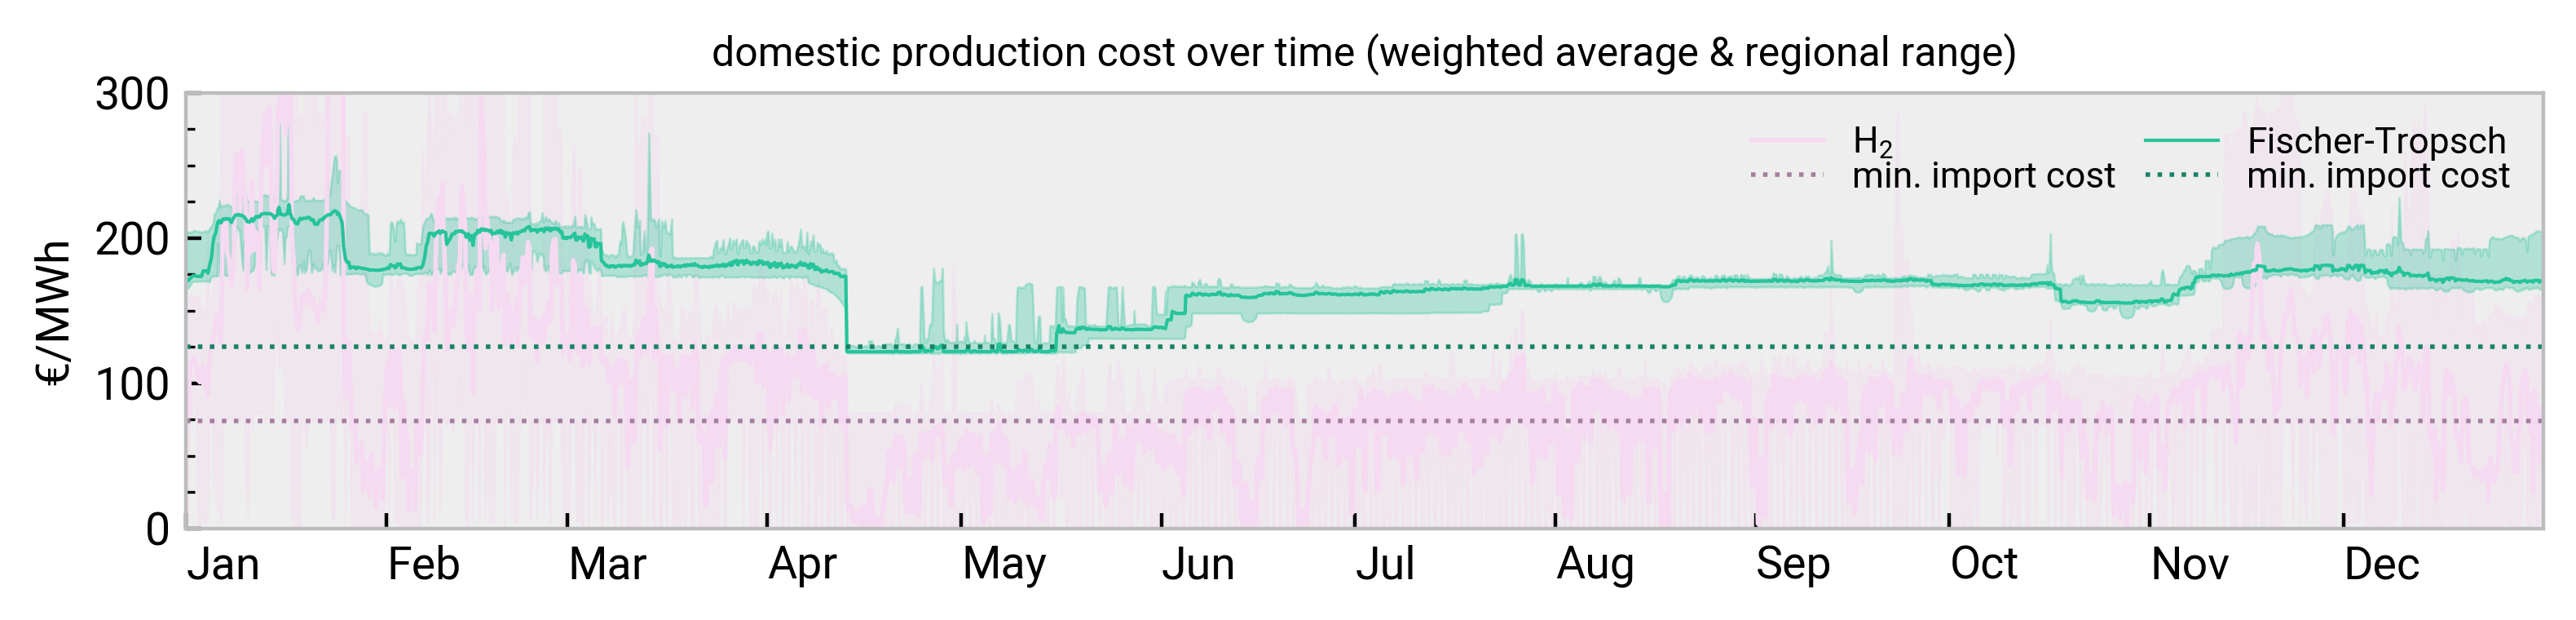

In [574]:
fig, ax_inset2 = fig, ax = plt.subplots(1, 1, figsize=(8, 2))

mean_values = (electrolysers_cost_t * electrolysers_h2_output).sum(
    axis=1
) / electrolysers_h2_output.sum()
min_values = electrolysers_cost_t.min(axis=1)
max_values = electrolysers_cost_t.max(axis=1)

mean_values.plot(ax=ax_inset2, label=r"H$_2$", color="#f5daf1", linewidth=1)
ax_inset2.fill_between(
    electrolysers_cost_t.index, min_values, max_values, color="#f5daf1", alpha=0.3
)

ax_inset2.axhline(
    min_import_costs.groupby("carrier").min().at["hydrogen", "min"],
    color="#a67ea0",
    lw=1,
    linestyle=":",
    label="min. import cost",
)

mean_values = (ft_cost_t * ft_oil_output).sum(axis=1) / ft_oil_output.sum()
min_values = ft_cost_t.min(axis=1)
max_values = ft_cost_t.max(axis=1)

mean_values.plot(
    ax=ax_inset2,
    label="Fischer-Tropsch",
    color=tech_colors["Fischer-Tropsch"],
    linewidth=0.75,
)
ax_inset2.fill_between(
    ft_cost_t.index,
    min_values,
    max_values,
    color=tech_colors["Fischer-Tropsch"],
    alpha=0.3,
)

ax_inset2.axhline(
    min_import_costs.groupby("carrier").min().at["Fischer-Tropsch", "min"],
    color="#178266",
    lw=1,
    linestyle=":",
    label="min. import cost",
)

ax_inset2.legend(fontsize=8, ncol=2, labelspacing=0, columnspacing=0.8)

import matplotlib.dates as mdates
import matplotlib.ticker as ticker


class FirstLetterOfMonthFormatter(ticker.Formatter):
    def __init__(self):
        super().__init__()

    def __call__(self, x, pos=None):
        dt = mdates.num2date(x)
        return dt.strftime("%b")[:3]


ax_inset2.xaxis.set_major_formatter(FirstLetterOfMonthFormatter())
for label in ax_inset2.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment("left")

ax_inset2.set_ylim(0, 300)

ax_inset2.set_title(
    "domestic production cost over time (weighted average & regional range)",
    fontsize=9,
)
ax_inset2.set_ylabel("€/MWh", fontsize=10)
ax_inset2.set_xlabel("")
ax_inset2.set_xlim("2013-01-01 00:00", "2013-12-31 23:00")
ax_inset2.grid(False)
# ax_inset2.set_facecolor("white")
ax_inset2.set_yticks(range(0, 300, 25), minor=True)
# for i in ["top", "right", "left", "bottom"]:
#     ax_inset2.spines[i].set_visible(False)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/market-value-ts-{scenario_name}{ext}", bbox_inches="tight")

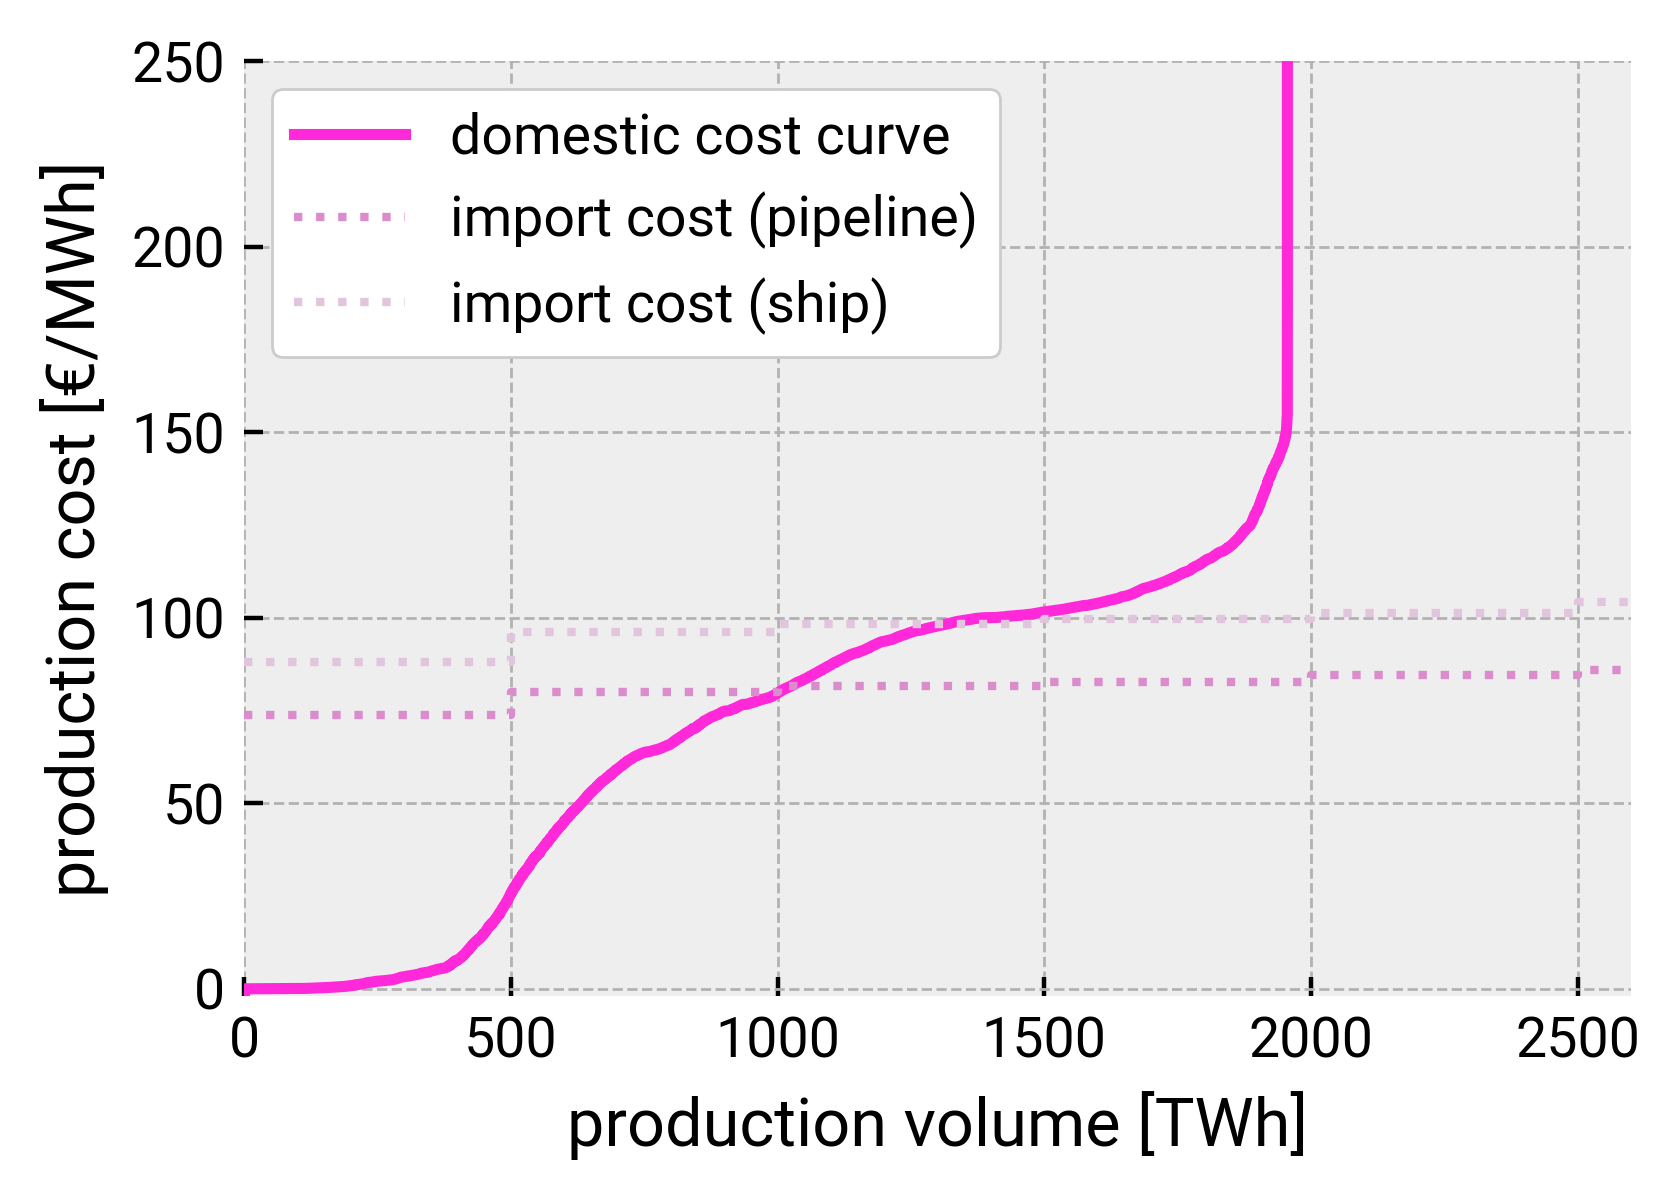

In [575]:
csc = (
    pd.concat(
        {
            "mv": electrolysers_cost_t.stack(),
            "vol": electrolysers_h2.mul(n.snapshot_weightings.generators, axis=0)
            .stack()
            .div(1e6),  # TWh
        },
        axis=1,
    )
    .sort_values(by="mv")
    .reset_index(drop=True)
)

csc["cum_vol"] = csc["vol"].cumsum()
fig, ax = plt.subplots(figsize=(4.3, 3.1))
plt.plot(
    csc["cum_vol"],
    csc["mv"],
    marker="none",
    linestyle="-",
    color=tech_colors["H2 Electrolysis"],
    label="domestic cost curve",
)
plt.ylabel("production cost [€/MWh]")
plt.xlabel("production volume [TWh]")
ax.set_xlim(0, 2600)
ax.set_ylim(-2, 250)

values = (
    min_import_costs["min"].xs("hydrogen", level="carrier").sort_values().values[:6]
)
x = np.arange(0, 500 * len(values), 500)
y_steps = np.repeat(values, 2)
x_steps = np.hstack([[x_val, x_val + 500] for x_val in x])
ax.plot(
    x_steps,
    y_steps,
    drawstyle="steps-post",
    label="import cost (pipeline)",
    linestyle=":",
    linewidth=1.5,
    color=tech_colors["import pipeline-h2"],
)

values = (
    min_import_costs["min"]
    .xs("hydrogen (ship)", level="carrier")
    .sort_values()
    .values[:6]
)
x = np.arange(0, 500 * len(values), 500)
y_steps = np.repeat(values, 2)
x_steps = np.hstack([[x_val, x_val + 500] for x_val in x])
ax.plot(
    x_steps,
    y_steps,
    drawstyle="steps-post",
    label="import cost (ship)",
    linestyle=":",
    linewidth=1.5,
    color=tech_colors["import shipping-lh2"],
)

plt.legend(frameon=True, facecolor="white", framealpha=1)

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/csc-h2-{scenario_name}{ext}", bbox_inches="tight")

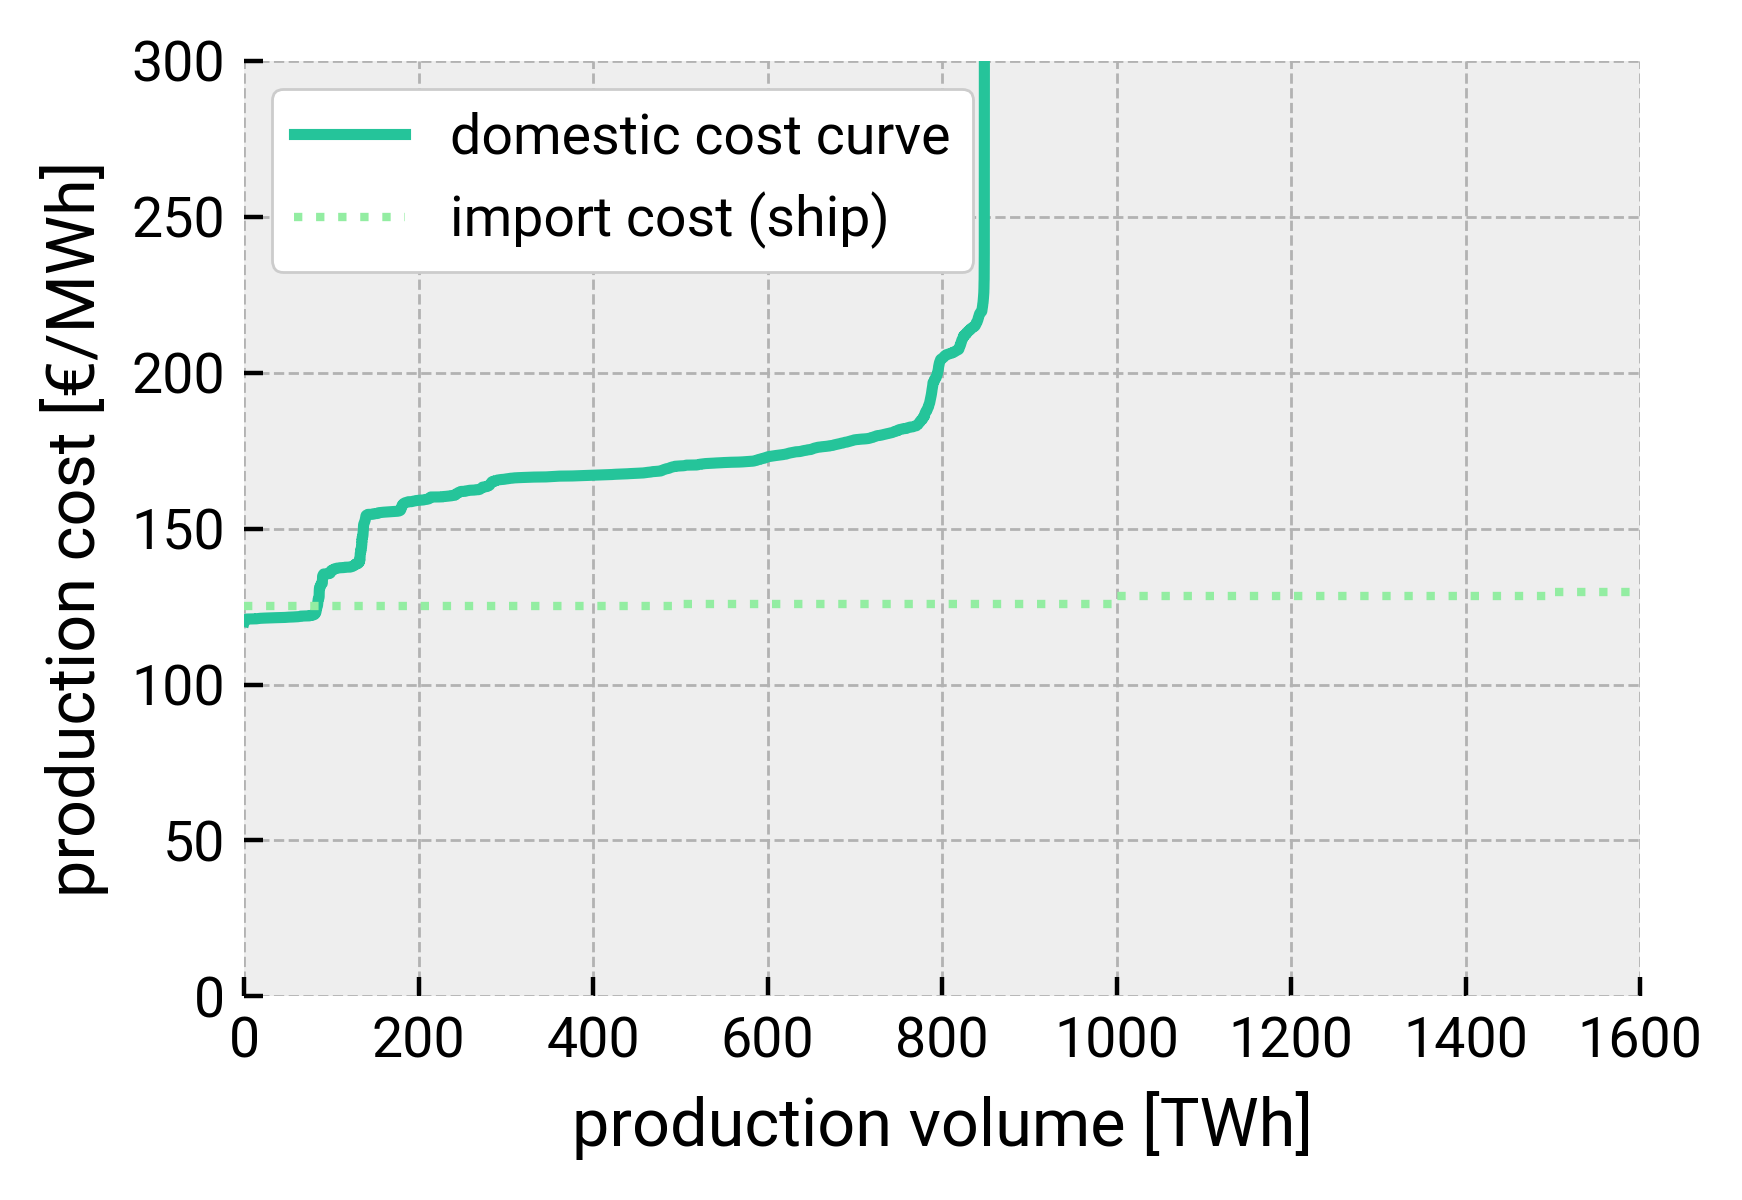

In [576]:
csc = (
    pd.concat(
        {
            "mv": ft_cost_t.stack(),
            "vol": ft_oil.mul(n.snapshot_weightings.generators, axis=0)
            .stack()
            .div(1e6),  # TWh
        },
        axis=1,
    )
    .sort_values(by="mv")
    .reset_index(drop=True)
)

csc["cum_vol"] = csc["vol"].cumsum()
fig, ax = plt.subplots(figsize=(4.3, 3.1))
plt.plot(
    csc["cum_vol"],
    csc["mv"],
    marker="none",
    linestyle="-",
    color=tech_colors["Fischer-Tropsch"],
    label="domestic cost curve",
)
plt.ylabel("production cost [€/MWh]")
plt.xlabel("production volume [TWh]")
ax.set_xlim(0, 1600)
ax.set_ylim(0, 300)

values = (
    min_import_costs["min"]
    .xs("Fischer-Tropsch", level="carrier")
    .sort_values()
    .values[:5]
)
x = np.arange(0, 500 * len(values), 500)
y_steps = np.repeat(values, 2)
x_steps = np.hstack([[x_val, x_val + 500] for x_val in x])
ax.plot(
    x_steps,
    y_steps,
    drawstyle="steps-post",
    label="import cost (ship)",
    linestyle=":",
    linewidth=1.5,
    color=tech_colors["import shipping-ftfuel"],
)


plt.legend(frameon=True, facecolor="white", framealpha=1)


for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/csc-ftf-{scenario_name}{ext}", bbox_inches="tight")

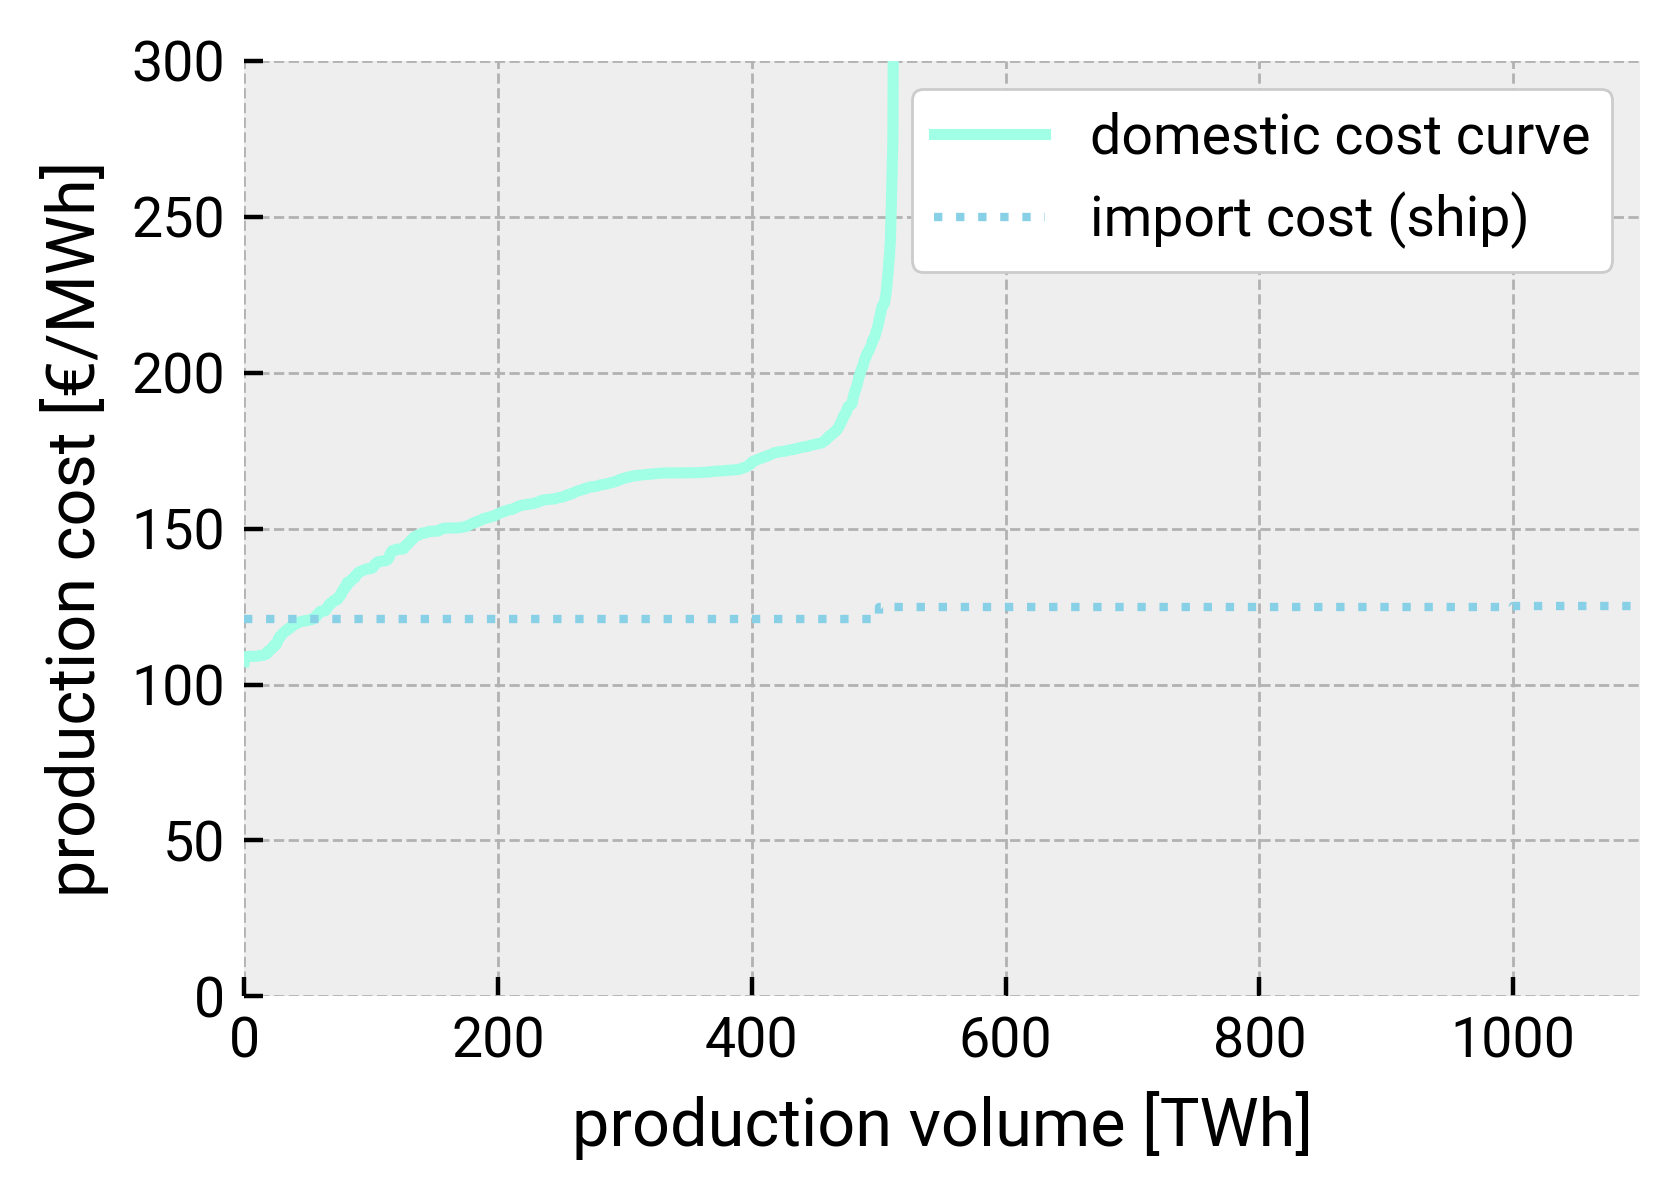

In [577]:
csc = (
    pd.concat(
        {
            "mv": meoh_cost_t.stack(),
            "vol": meoh_meoh.mul(n.snapshot_weightings.generators, axis=0)
            .stack()
            .div(1e6),  # TWh
        },
        axis=1,
    )
    .sort_values(by="mv")
    .reset_index(drop=True)
)

csc["cum_vol"] = csc["vol"].cumsum()
fig, ax = plt.subplots(figsize=(4.3, 3.1))
plt.plot(
    csc["cum_vol"],
    csc["mv"],
    marker="none",
    linestyle="-",
    color=tech_colors["methanolisation"],
    label="domestic cost curve",
)
plt.ylabel("production cost [€/MWh]")
plt.xlabel("production volume [TWh]")
ax.set_xlim(0, 1100)
ax.set_ylim(0, 300)


values = (
    min_import_costs["min"].xs("methanol", level="carrier").sort_values().values[:5]
)
x = np.arange(0, 500 * len(values), 500)
y_steps = np.repeat(values, 2)
x_steps = np.hstack([[x_val, x_val + 500] for x_val in x])
ax.plot(
    x_steps,
    y_steps,
    drawstyle="steps-post",
    label="import cost (ship)",
    linestyle=":",
    linewidth=1.5,
    color=tech_colors["import shipping-meoh"],
)

plt.legend(frameon=True, facecolor="white", framealpha=1)

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)

for ext in [".png", ".pdf"]:
    plt.savefig(f"{RUN}/csc-meoh-{scenario_name}{ext}", bbox_inches="tight")